# Итоговое задание юнита 3
# Проект о вкусной и здоровой пище

В рамках данного проекта я должен подготовить данные для машинного обучения с использованием метода решающих деревьев библиотеки Scikit-Learn.
Для этих целей необходимо будет обработать исходные данные, а затем подготовить их в корректном виде для подхода. Особое внимание следует уделять методам заполнения пропусков, поскольку удалять строчки с пропусками это самый крайний подход, который может быть.
В процессе анализа исходных данных будут сделаны попытки изменения старых и построения новых признаков.

Загружаем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import re

import warnings

## Предобработка

In [2]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

warnings.filterwarnings("ignore") # Убираем все информационные сообщения

DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'

pd.set_option('display.max_columns', 300) # Показывать все столбцы в наборе
sns.set(style='darkgrid')                 # Для глаза приятнее

RANDOM_SEED = 42

#+++++++++++++++++++++++++++

def date_analise(svalue):
    """
    Функция применяется для проведения анализа временных характеристик
    """
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 14)) 
    fig.subplots_adjust(wspace=0.1); fig.subplots_adjust(hspace=0.2)
    [ax[i,j].set_title('Cтолбец отзывов № '+svalue, fontsize = 17) for i in range(2) for j in range(2)]; 

    col = 'date_'+svalue
    
    # Years
    years = copy_data[col].dt.year.value_counts().reset_index().rename({'index': 'years', col: 'count'}, axis=1)
    years['years'] = years['years'].apply(int)
    years = years.sort_values(by='years')
    years_val = years['years'].values
    
    # Месяцы:
    months = copy_data[col].dt.month.value_counts().reset_index().rename({'index': 'months', col: 'count'}, axis=1)
    months['months'] = months['months'].apply(int)
    months = months.sort_values(by='months')
    months_val = months['months'].values
    
    # Дни месяца:
    days = copy_data[col].dt.day.value_counts().reset_index().rename({'index': 'days', col: 'count'}, axis=1)
    days['days'] = days['days'].apply(int)
    days = days.sort_values(by='days')
    days_val = days['days'].values
    
    # Дни недели:
    dweek = copy_data[col].dt.dayofweek.value_counts().reset_index().rename({'index': 'day_of_week', col: 'count'}, axis=1)
    dweek['day_of_week'] = dweek['day_of_week'].apply(int)
    dweek = dweek.sort_values(by='day_of_week')
    dweek_val = dweek['day_of_week'].values
  
    # Построение гистограмм
    # Годы
    sns.barplot(x='years', y='count', data=years, ci=None, orient='v',  ax=ax[0,0], order=years_val);
    ax[0,0].set_xlabel('years', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[0,0].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    ax[0,0].set_yticks([y for y in range(0, 35000, 5000)]);

    # Месяцы
    sns.barplot(x='months', y='count', data=months, ci=None, orient='v',  ax=ax[0,1], order=months_val);
    ax[0,1].set_xlabel('months', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[0,1].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    ax[0,1].set_yticks([y for y in range(0, 6000, 500)]);
    
    # Дни
    sns.barplot(x='days', y='count', data=days, ci=None, orient='v',  ax=ax[1,0], order=days_val);
    ax[1,0].set_xlabel('days', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[1,0].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    ax[1,0].set_yticks([y for y in range(0, 1800, 200)]);
    
    # Дни недели
    sns.barplot(x='day_of_week', y='count', data=dweek, ci=None, orient='v',  ax=ax[1,1], order=dweek_val);
    ax[1,1].set_xlabel('day_of_week', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[1,1].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    ax[1,1].set_yticks([y for y in range(0, 8000, 1000)]);

#+++++++++++++++++++++++++++

def cuisine_update(cuisine):
    """
    Преобразуем строку в должный вид: сортировка.
    Эта операция необходима:
       во-первых - могут встречаться сочетания стилей в разных ресторанах
       во-вторых - value_counts не работает с листами в kaggle notebook
    """

    if pd.isna(cuisine): return 'Unk' # Если что-то идёт не так забьём строчкой Unk
    
    cuisine_ = [cstr.replace(' ','').replace('\'','') for cstr in cuisine.strip('[ ]').split(',')]
    cuisine_.sort()
    
    cuisine = cuisine_[0]
    for cstr in cuisine_[1:]:
        cuisine = cuisine + ', ' + cstr
        
    return cuisine

#+++++++++++++++++++++++++++

def cuisine_list(cuisine):
    """
    Фунция преобравзования стилей кухонь к списку
    """
    if cuisine =='Unk': return ['Unk']
    return [cstr for cstr in cuisine.replace('\'','').split(', ')]

#+++++++++++++++++++++++++++    

def fill_ncuisine(row):
    '''
    Функция заполняющая пропуски в кухнях национальными кухнями
    '''
    if row.Cuisine_Style==['Unk']:
        row.Cuisine_Style = national_cuisine.loc[row.Country]
    return row


Загружаем рабочие датасеты.

In [3]:
main_task = pd.read_csv(DATA_DIR+'/main_task.csv')     # На этом датасете будем учиться в Feature..и проводить обучение
kaggle_task = pd.read_csv(DATA_DIR+'kaggle_task.csv')  # Проверочный датасет, будем проверять, как получилось обучить

Посмотрим хэды.

In [4]:
main_task.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
kaggle_task.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


В кэггле нет рейтинга, давайте сделаем его и занулим до поры времени.

In [6]:
kaggle_task['Rating'] = 0

Поскольку данные из набора kaggle_task необходимо будет обработать аналогичным образом как и обучающий набор, то разумно сделать склейку данных наборов, предварительно пометив учебный набор и проверочный. Для этого непосредственно перед объединением двух наборов к загруженным дата сэтам добавим новый признак **flag**, который отделит набор для обучения и тестовый набор.

In [7]:
# Набор для обучения
main_task['flag'] = 1

# Набор для проверки
kaggle_task['flag'] = 0

# Новый набор
data = kaggle_task.append(main_task, sort=False)

# Чтобы индексы не повторялись сбросим их
data = data.reset_index(drop=True)

Давайте посмотрим, что получилось.

In [8]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,flag
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0.0,0


Также полезно посмотреть.

In [9]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
Rating               50000 non-null float64
flag                 50000 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Ranking,Number of Reviews,Rating,flag
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,3.194430,0.800000
std,3700.092452,294.114345,1.705453,0.400004
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,3.000000,1.000000
50%,2278.000000,33.000000,4.000000,1.000000
75%,5241.000000,115.000000,4.500000,1.000000
max,16444.000000,9660.000000,5.000000,1.000000


Видим, что числовых признаков мало.. Надо что-то делать будет; + есть пропуски, с ними тоже надо будет разобраться.

Как мы видим, некоторые столбцы имеют не очень удобное название - несколько слов через пробел. В дальнейшем для исключения ошибок я сменю имена колонок, чтобы иметь возможность написания признаков через точку, а не только квадратные скобки и кавычки.

In [10]:
# Изменяем имена для удобства
data.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range', 'Number_of_Reviews',
                'Reviews', 'URL_TA', 'ID_TA', 'Rating', 'flag']

In [11]:
data.iloc[0] # Посмотрим, как получилось..

Restaurant_id                                                     id_0
City                                                             Paris
Cuisine_Style                                           ['Bar', 'Pub']
Ranking                                                          12963
Price_Range                                                   $$ - $$$
Number_of_Reviews                                                    4
Reviews                                                       [[], []]
URL_TA               /Restaurant_Review-g187147-d10746918-Reviews-L...
ID_TA                                                        d10746918
Rating                                                               0
flag                                                                 0
Name: 0, dtype: object

## Анализ ситуации с пропусками

Предлагаю взглянуть на 'поражение данных' качественно.

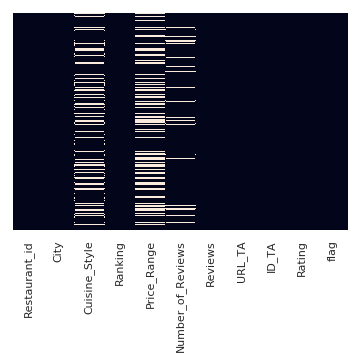

In [12]:
# Построим тепловую какрту. Там где пропуски - должно быть белым, остальное чёрным
fig, ax = plt.subplots()
sns.heatmap(data.isnull(), yticklabels=False, cbar=False);

Пропуски носят скорее случайный порядок, а не предопределённый (отсутствие данных целыми непрерывными блоками).

Давайте взглянем на количественные оценки.

In [13]:
data.isnull().sum() # Выведет сумму пропусков по всем столбцам

Restaurant_id            0
City                     0
Cuisine_Style        11590
Ranking                  0
Price_Range          17361
Number_of_Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
Rating                   0
flag                     0
dtype: int64

Большие проблемы с кухней, разбросом цен и количеством обзоров.

## 1. Анализ данных

## Rating

Рассмотрим целевую переменную Raiting, найдём количественные оценки.

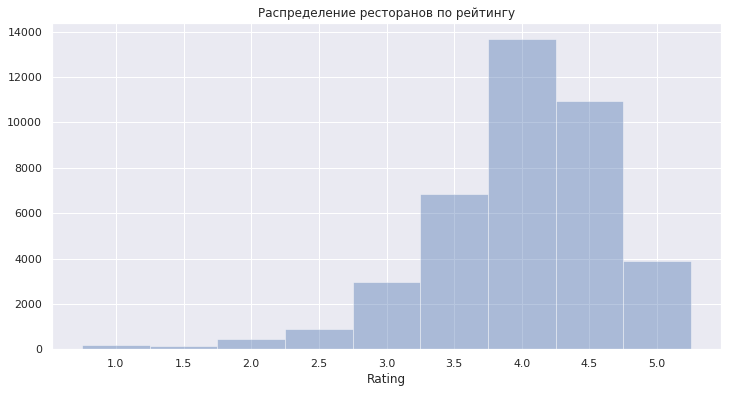

In [14]:
# Выбираем только первоначальный набор main_task.
# И копируем, чтобы не испортить случайно его.
copy_data = data[data['flag']==1].copy()

# Рисуем..
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks(np.arange(1, 5.5, 0.5))
bins = [k for k in np.arange(1, 6, 0.5)]
prop = {'align': 'left'}
sns.distplot(copy_data.Rating, hist_kws = prop, kde=False, norm_hist=False, bins=bins)

# Делаем подпись
ax.set_title('Распределение ресторанов по рейтингу');

Посмотрим характеристики центральной тенденции выборки.

In [15]:
median_value = copy_data.Rating.median();  # Медиана
mean_value = copy_data.Rating.mean()       # Мат. ожидание

# Вывод на экран
print(f'Медиана: {median_value};\nмат. ожидание: {mean_value}')

Медиана: 4.0;
мат. ожидание: 3.9930375


Самая встречающаяся оцена - 4. Распределение сдвинуто в область высоких оценок, тем не менее медиана и мат. ожидание очень похожи друг на друга.

## Ranking

Данный признак несёт дополнительную информацию о месте ресторана в город, в смысле по каким-то местным суждениям. Это дополнительный числовой параметр. Исследуем на связь целевого признака и признак Ranking.

In [16]:
copy_data = data[data['flag']==1].copy()  # Чтоб не испортить
copy_data[['Ranking', 'Rating']].corr()   # Матрица корреляции

,Ranking,Rating
Ranking,1.000000,-0.368371
Rating,-0.368371,1.000000


Получается, что имеется некая взаимосвязь двух признаков. Причём, чем больше один, тем меньше другой. Есть подозрение, что чем выше рейтинг, тем ниже значение ранга. То есть этот признак может представлять собой субъективную оценку населения, и число 1 будет соответствовать ресторану, который считается в каком-то смысле лучшим. И наоборот. Построим количественную оценку.

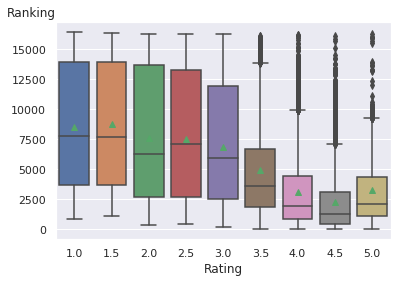

In [17]:
fig, ax = plt.subplots();
sns.boxplot(x='Rating', y='Ranking', data=copy_data, showmeans=True, ax=ax);
ax.set_ylabel('Ranking', rotation=0, position=(0, 1.01), ha='left');

Предположение подтверждается, что чем больше рейтинг, тем ресторан на 'первых полосах газет' (в хорошем смысле). Также и разброс куда меньше, что говорит, что хорошие рестораны держут марку.

Ретинг может повторяться? Проверим для ранга это предположение.

In [18]:
copy_data = data.groupby('City').Ranking.agg(['min', 'max', 'count', 'nunique']).sort_values(by='count', ascending=False)
copy_data['residual'] = copy_data['nunique'] - copy_data['count']
display(copy_data)
print('\nГорода с рангом 1')
copy_data[copy_data['min']==1][['min']].T

,min,max,count,nunique,residual
City,,,,,
London,1.0,16444.0,7193,7193,0
Paris,3.0,13986.0,6108,6108,0
Madrid,1.0,8809.0,3813,3813,0
Barcelona,5.0,7796.0,3395,3395,0
Berlin,2.0,6372.0,2705,2705,0
Milan,1.0,6275.0,2694,2694,0
Rome,1.0,5948.0,2589,2589,0
Prague,2.0,4188.0,1816,1816,0
Lisbon,1.0,3717.0,1647,1647,0



Города с рангом 1


City,London,Madrid,Milan,Rome,Lisbon,Vienna,Amsterdam,Hamburg,Lyon,Stockholm,Budapest,Warsaw,Edinburgh,Krakow,Oslo
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Есть странность, в Варшаве 2 ресторана с одним рангом (может быть как в спроте, иногда побеждает дружба?). В остальном - предположение верное. Выше было предположение о взаимосвязи: чем выше рейтинг, тем ниже ранг. И наоборот. Интересно, может быть такое, что ресторан является заведомо плохим (ранг>>1), но рейтинг высокий. Ради примера возьмём Милан.

In [19]:
# Сначала возьмём худший в Милане
copy_data = data[data.City=='Milan']
display(copy_data[copy_data.Ranking==copy_data.Ranking.max()].URL_TA.values)

# Странный ресторан
copy_data = copy_data[copy_data.Rating==5]
display(copy_data[copy_data.Ranking==copy_data.Ranking.max()].URL_TA.values)

array(['/Restaurant_Review-g187849-d8338479-Reviews-Alexander-Milan_Lombardy.html'],
      dtype=object)

array(['/Restaurant_Review-g187849-d8600524-Reviews-Rockstar_Cafe_Bar_Tavola_Fredda-Milan_Lombardy.html'],
      dtype=object)

Зайдём и посмотрим на них. Худший ресторан Alexander.
![](https://downloader.disk.yandex.ru/preview/84e12acfd84c59b2f143e258cddd0261cb32e46b62e13e26c814a4f9812ddc49/60aed0e4/vEZ066jm0Dw8iz-3nLlezub8jyeSccNZx6jldCTeK9K4A8aXqMZP4QZkotYqYcBPG-8x9jGBSvIMpjEnIx7ZGQ%3D%3D?uid=0&filename=BadM.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)
Видим, что ранг большой, рейтинг маленький. Всего один отзыв за всё время.Даже фото нет.

Теперь посмотрим на один из 'лучших' ресторанов, но с высоким рангом - Rockstar Cafe Bar & Tavola Fredda.
![](https://downloader.disk.yandex.ru/preview/9c9854289739de685c57472f16f0b2369f323489d3875ac50256a2cee0ec6982/60aed16f/YbzmCEDrqy4ZfpDElNV328OGsWDjGn2lZvPiLoW97QCmEQqlbJewcp_iUTQ8WV5BC1VqFsGbW-yPKNgGyiZ84g%3D%3D?uid=0&filename=BBestM.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=1860x937)
Всего два отзыва, ранг не сильно далёк от первого. Хотя в отзывах пишут, что тихое уютное место с хорошим кофе (перевёл через онлайн переводчик). Но на ресторан не тянет на мой взгляд, фотка будто кафешка, что подтверждает второй отзыв. И вполне возможно, что эти отзывы фейковые, кто-то из друзей знакомых их сделал.

Взглянем на лучший ресторан Милана.

In [20]:
# Лучший ресторан
display(copy_data[copy_data.Ranking==copy_data.Ranking.min()].URL_TA.values)

array(['/Restaurant_Review-g187849-d12949211-Reviews-Dersett-Milan_Lombardy.html'],
      dtype=object)

Однако.. Видимо дата сэт устарел, лучший ресторан имеет лишь 4.5 звезды на сегодняшний день. Тем не менее, по фотографиям видно, что очень уютное место, что говорят 523 отзыва (и снова спасибо онлайн переводчику) и тот факт что он входит 5% лучших ресторанов по мерках туристов и местных жителей.. миланогородцев.. миланодчан...
![](https://downloader.disk.yandex.ru/preview/de247bf0aeae9eeb19c53b8b0f9c84b68e95f6b94f11ac5b841ba32aac32837e/60aed21d/O6FiS2VuiyMIsrqFO5YgCZG_fvTiBwx-P33j8jeem9tiWvQGqO1j-TUIzUCZFNyuBMqYlXzqRjqEmOkhNuDn-w%3D%3D?uid=0&filename=BestM.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)

Предлагаю продолжить. Посмотрим, что там в Цюрихе. Сначала выведу ресторан с минимальным рангом, а затем лучший по рейтингу и лучший по рангу и сравним их.

In [21]:
# Самый лучшмий по рангу
copy_data = data[data.City=='Zurich']
display(copy_data[copy_data.Ranking==copy_data.Ranking.min()].URL_TA.values)

# Самый лучший по рангу и рейтингу:
copy_data = copy_data[copy_data.Rating==5]
display(copy_data[copy_data.Ranking==copy_data.Ranking.min()].URL_TA.values)

array(['/Restaurant_Review-g188113-d10169867-Reviews-Tamarind_Hill_Indian_Restaurant-Zurich.html'],
      dtype=object)

array(['/Restaurant_Review-g188113-d12284542-Reviews-Restaurant_Nihao-Zurich.html'],
      dtype=object)

Оказывается в Швейцарии очень любят экзотику. Ресторан Tamarind Hill Indian Restaurant 32 место из всех в Цюрихе.
![](https://downloader.disk.yandex.ru/preview/17107e35edb3b7f4109d75d84619be5439d022fdd9351e19225ff45c80c7d551/60aed2a4/wy93Q2N2VvIq07qBNI8HI5G_fvTiBwx-P33j8jeem9tQEwgNEMHDreG4yVgi2fEm13Qjhr7P66Gf1HXhpvUKTg%3D%3D?uid=0&filename=tam.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)
Видим, что его рейтинг - 4.5. Почти 700 отзывов очень хороший результат!

естран с рейтингом 5 и минимальным рангом из всех пятёрок: Restaurant Nihao.
![](https://downloader.disk.yandex.ru/preview/ab291020b24a9abf9f2a020eb763b7316e4bb6f7dd49c7b46a2e3d9d31cc3526/60aed32f/u8N6u_Hi_NDtAC2GyKzIFpG_fvTiBwx-P33j8jeem9teGkiX3Pmdhsy1aIMdHafrbJOe1lkO0MjCKrWCLFLHig%3D%3D?uid=0&filename=nih.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=1860x937)
Более 200 отзывов и четвёртое место в Цюрихе. Очень крутое место наверное.

Тем не менее, получать одни пятёрки очень сложно, так как люди бывают разные, бывают скандальные, бывают уставшие и угодить всем очень сложно. Поэтому самый широко встсречающийся рэйтинг - 4.5.


Выше приводилось общее распределение ранга и рейтинга, поэтому предлагаю посмотреть подобную оценку по Цюриху и Милану. Внимание, ввиду того, что максимальный ранг может сильно отличаться по городам, то разумно нормировать, чтобы иметь сравнимые значения.

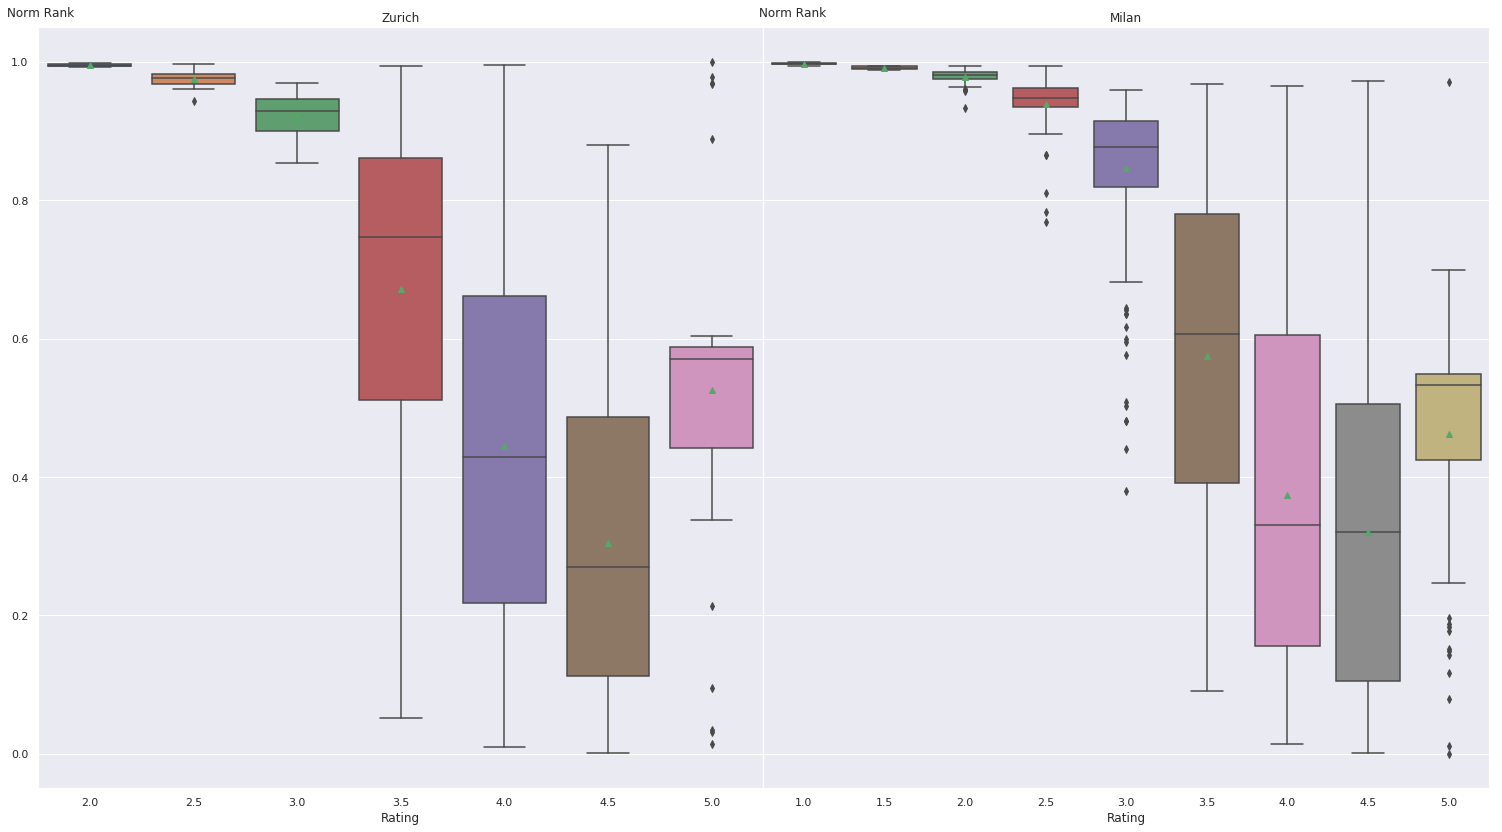

In [22]:
# Чтоб не испортить
copy_data = data[data['flag']==1][['Rating', 'Ranking', 'City']].copy()

copy_data.loc[copy_data.City=='Zurich', 'Ranking'] = copy_data.loc[copy_data.City=='Zurich', 'Ranking'] / copy_data[copy_data.City=='Zurich'].Ranking.max()
copy_data.loc[copy_data.City=='Milan', 'Ranking'] = copy_data.loc[copy_data.City=='Milan', 'Ranking'] / copy_data[copy_data.City=='Milan'].Ranking.max()

fig, ax = plt.subplots(1, 2, figsize=(26, 14), sharey=True);
fig.subplots_adjust(wspace=0);

sns.boxplot(x='Rating', y='Ranking', data=copy_data[copy_data.City=='Zurich'], ax=ax[0], showmeans=True);
sns.boxplot(x='Rating', y='Ranking', data=copy_data[copy_data.City=='Milan'],  ax=ax[1], showmeans=True);

ax[0].set_title('Zurich');
ax[1].set_title('Milan');
ax[0].set_ylabel('Norm Rank', rotation=0, position=(0,1.01), ha='left');
ax[1].set_ylabel('Norm Rank', rotation=0, position=(0,1.01), ha='left');


Видим, что распределения подобны тому, что было ранее.

Базовое предположение подтверждается, чем выше рейтинг ресторана, тем ниже его ранг и наоборот. Ранг есть уникальное в рамках города число. Минимальный ранг имеют рестораны с оценкой 4.5.

## City


Выведем все города в дата сэте, их количество и количество ресторанов в них.


In [23]:
# Сделаем серию с количеством ресторанов в городе
rest_city = pd.DataFrame(data.City.value_counts())
rest_city.columns = ['Count of Rest.']
print(rest_city)

copy_data = data.copy()      # Rопируем, чтобы не испортить случайно.
count = copy_data.City.nunique() # Cколько уникальных
print(f'\nКоличество уникальных городов: {count}')

            Count of Rest.
London                7193
Paris                 6108
Madrid                3813
Barcelona             3395
Berlin                2705
Milan                 2694
Rome                  2589
Prague                1816
Lisbon                1647
Vienna                1443
Amsterdam             1372
Brussels              1314
Hamburg               1186
Munich                1145
Lyon                  1126
Stockholm             1033
Budapest              1021
Warsaw                 925
Dublin                 836
Copenhagen             819
Athens                 776
Edinburgh              745
Zurich                 685
Oporto                 642
Geneva                 590
Krakow                 554
Oslo                   488
Helsinki               475
Bratislava             380
Luxembourg             263
Ljubljana              222

Количество уникальных городов: 31


Чем города могут отличаться от друг от друга в рамках присваивания рейтинга ресторанам? Построим гистограммы по первым 5 городам и последним 5 городам (разумеется для тех, где есть рейтинг).

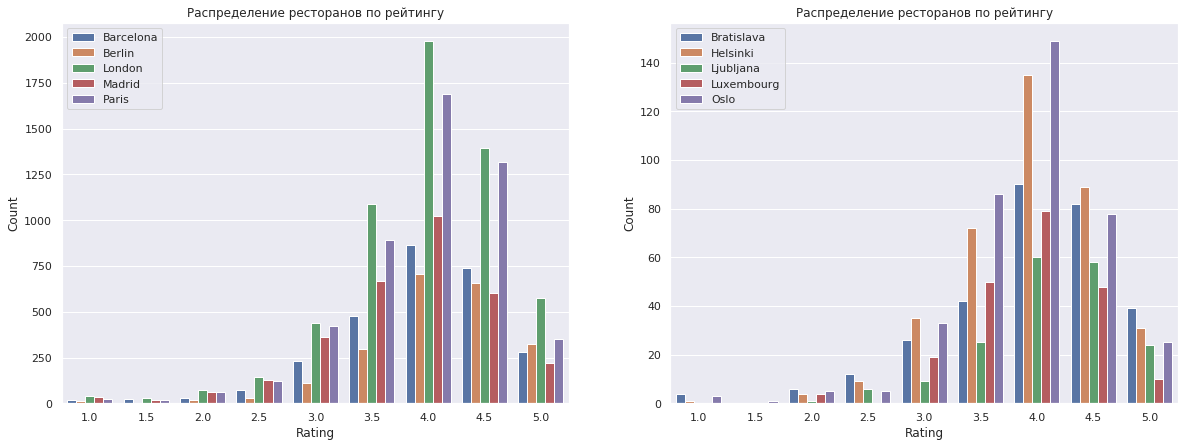

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7));
[axs.set_xticks(np.arange(1, 5.5, 0.5)) for axs in ax] # Наборы осей

# Лондон, Париж, Мадрид, Барселона, Берлин
copy_data = data[data['flag']==1].copy()
first5 = copy_data[copy_data.City.isin(['London', 'Paris', 'Madrid',
        'Barcelona', 'Berlin'])].groupby(['City', 'Rating']).ID_TA.count()
first5 = first5.reset_index().rename({'ID_TA': 'Count'}, axis='columns')

# Осло, Хелсинки, Братислава, Люксембург, Любляна (надеюсь с последним не ошибся..)
end5 = copy_data[copy_data.City.isin(['Oslo', 'Helsinki', 'Bratislava',
        'Luxembourg', 'Ljubljana'])].groupby(['City', 'Rating']).ID_TA.count()
end5 = end5.reset_index().rename({'ID_TA': 'Count'}, axis='columns')

# Рисуем
sns.barplot(x='Rating', y='Count', hue='City', data=first5, ci=None, ax=ax[0])
sns.barplot(x='Rating', y='Count', hue='City', data=end5, ci=None, ax=ax[1])

ax[1].set_yticks(range(0, 160, 20));
[axs.legend(loc='upper left') for axs in ax];
[axs.set_title('Распределение ресторанов по рейтингу') for axs in ax];

Как видно из представленных результатов, рейтинг в разных городах имеет схожую картину.

## Review

Данный признак содержит пару отзывов с датами публикации. Предварительный анализ показал, что в наборе присутствует 2 пропуска.

In [25]:
# Найдём информацию по ним в поле URL_TA
print(f'{data[data.Reviews.isnull()].URL_TA.values[0]}\n{data[data.Reviews.isnull()].URL_TA.values[1]}')

/Restaurant_Review-g189158-d12683988-Reviews-O_Sitar-Lisbon_Lisbon_District_Central_Portugal.html
/Restaurant_Review-g190454-d12605368-Reviews-Rochus-Vienna.html


Посмотрим как выглядит образец Review.

In [26]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Давайте найдём два последних отзыва по этим двум ресторанам на TripAdvisor.

Выбрал для первого ресторана O SITAR такие: Indian flavour 03/09/2020 и fraco 01/27/2020

Для второго - ROCHUS такие отзывы: KEINE Kundenorientierung 04/09/2021 и Could be 4 stars really... 10/30/2020

Найдём индексы строк с пропусками и заполним их.

In [27]:
print(f'Индексы строк пропусков: {data[data.Reviews.isnull()].index[0]}, {data[data.Reviews.isnull()].index[1]}')

Индексы строк пропусков: 8168, 9608


In [28]:
data.loc[8168, 'Reviews'] = "[['Indian flavour ', 'fraco'], ['03/09/2020', '01/27/2020']]"
data.loc[9608, 'Reviews'] = "[['KEINE Kundenorientierung', 'Could be 4 stars really...'], ['04/09/2021', '10/30/2020']]"

Давайте проанализируем даты публикаций и постараемся найти что-то интересное.

In [29]:
copy_data = data.copy() # Чтобы не испортить

# Для вычленения даты воспользуемся регулярными выражениями
pattern = re.compile('\d+\/\d+\/\d+')

# Создадим новый столбец
copy_data['dates'] = copy_data['Reviews'].apply(pattern.findall)
copy_data['dates'].sample(10)

26624                [07/16/2017]
15585    [01/19/2016, 08/13/2015]
88       [01/01/2017, 05/01/2016]
44077    [11/26/2017, 10/01/2017]
47838    [03/23/2017, 08/23/2016]
25286    [12/31/2017, 11/07/2017]
34087    [10/22/2017, 08/28/2017]
23367    [01/07/2018, 12/18/2017]
8921                 [11/14/2017]
22807    [02/19/2017, 05/29/2017]
Name: dates, dtype: object

На всякий случай отсортируем по дате с учётом того, что вторая дата может отсутствовать.

In [30]:
# Отдельно обрабатываем строки, где дата в обзоре
copy_data['dates'] = copy_data['dates'].apply(lambda x: [x[-2], x[-1]] if len(x)>=3 else x)

# Сортируем
copy_data['dates'] = copy_data['dates'].apply(pd.to_datetime).apply(sorted)

# Одна дата
copy_data['date_1'] = copy_data['dates'].apply(lambda x: x[0] if len(x)>=1 else None)

# Две даты
copy_data['date_2'] = copy_data['dates'].apply(lambda x: x[1] if len(x)==2 else None)

Найдём в дата сэте самую первую и самую последнюю даты.

In [31]:
print(f"Последняя дата: {copy_data[['date_1', 'date_2']].max().max().strftime('%d-%m-%Y')}")
print(f"Первая дата: {copy_data[['date_1', 'date_2']].min().min().strftime('%d-%m-%Y')}")

Последняя дата: 09-04-2021
Первая дата: 21-04-2004


Для проверки найдём самый первый отзыв. Он наверняка должен быть в этом дата сэте.

In [32]:
copy_data[copy_data.date_1==copy_data.date_1.min()].URL_TA.values

array(['/Restaurant_Review-g190454-d694328-Reviews-Babu-Vienna.html'],
      dtype=object)

Совпало! Дата 21 апреля 2004 года.
![](https://downloader.disk.yandex.ru/preview/4182d2f44494086cf8cf8b30112487644bc45827e6af3cf13ac0d0b74e5ca053/60aed5d2/xI1G06dIuz2ge9mxgbUlh8OGsWDjGn2lZvPiLoW97QA4Wgejzi_ee7--3X6sxuZiYIvPmSPIsd7KakRuT31ktA%3D%3D?uid=0&filename=First.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)

Создадим новый признак - количество дней между двумя отзывами.

In [33]:
copy_data['days_number'] = abs(copy_data.date_2 - copy_data.date_1).dt.days

Все пропуски заполним медианой.

In [34]:
median_val = copy_data.days_number.median()
copy_data['days_number'] = copy_data.days_number.fillna(median_val)

data_reviews = copy_data[['Restaurant_id', 'days_number']]
data_reviews

,Restaurant_id,days_number
0,id_0,67.0
1,id_1,37.0
2,id_2,22.0
3,id_3,14.0
4,id_4,15.0
...,...,...
49995,id_499,34.0
49996,id_6340,9.0
49997,id_1649,3127.0
49998,id_640,23.0


Проведём анализ date_1 и date_2 по годам, месяцам, дням и дням недели.Проведём анализ date_1 и date_2.

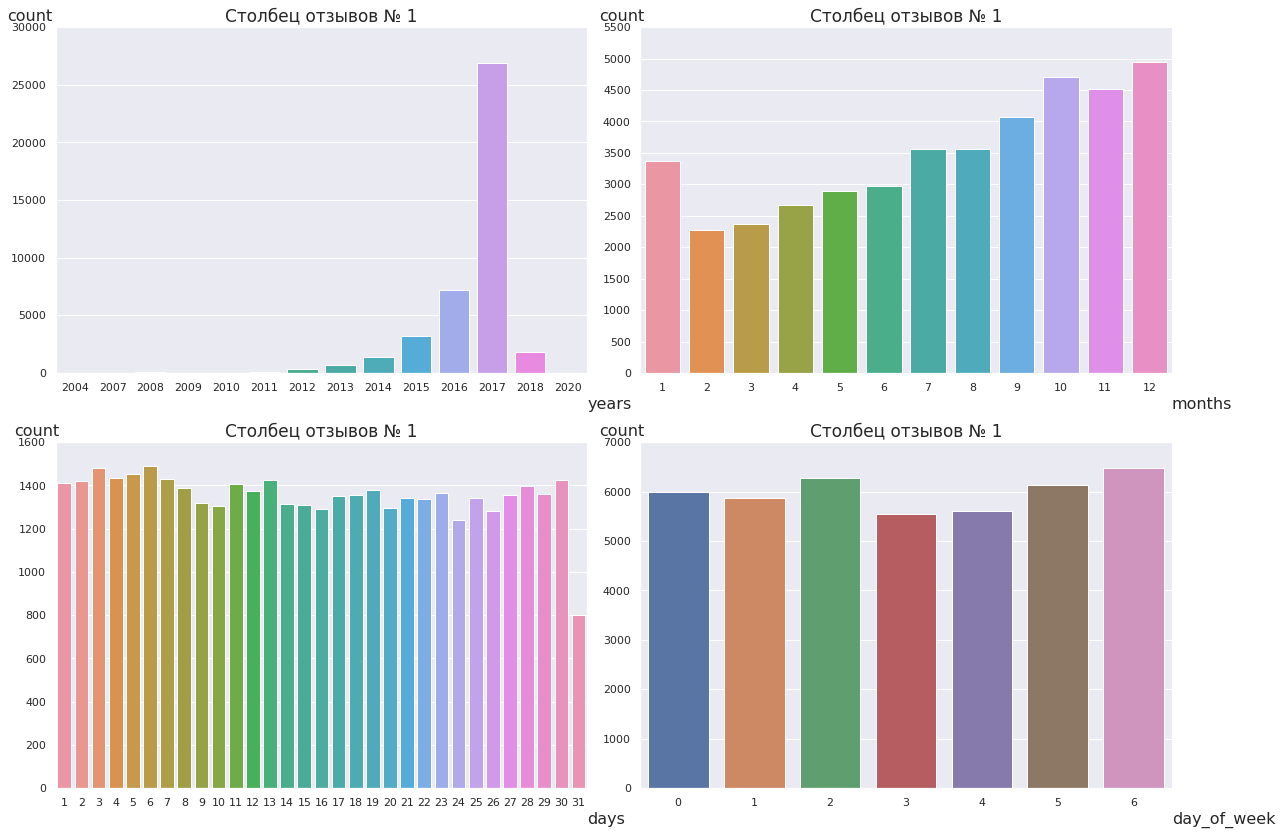

In [35]:
date_analise('1')

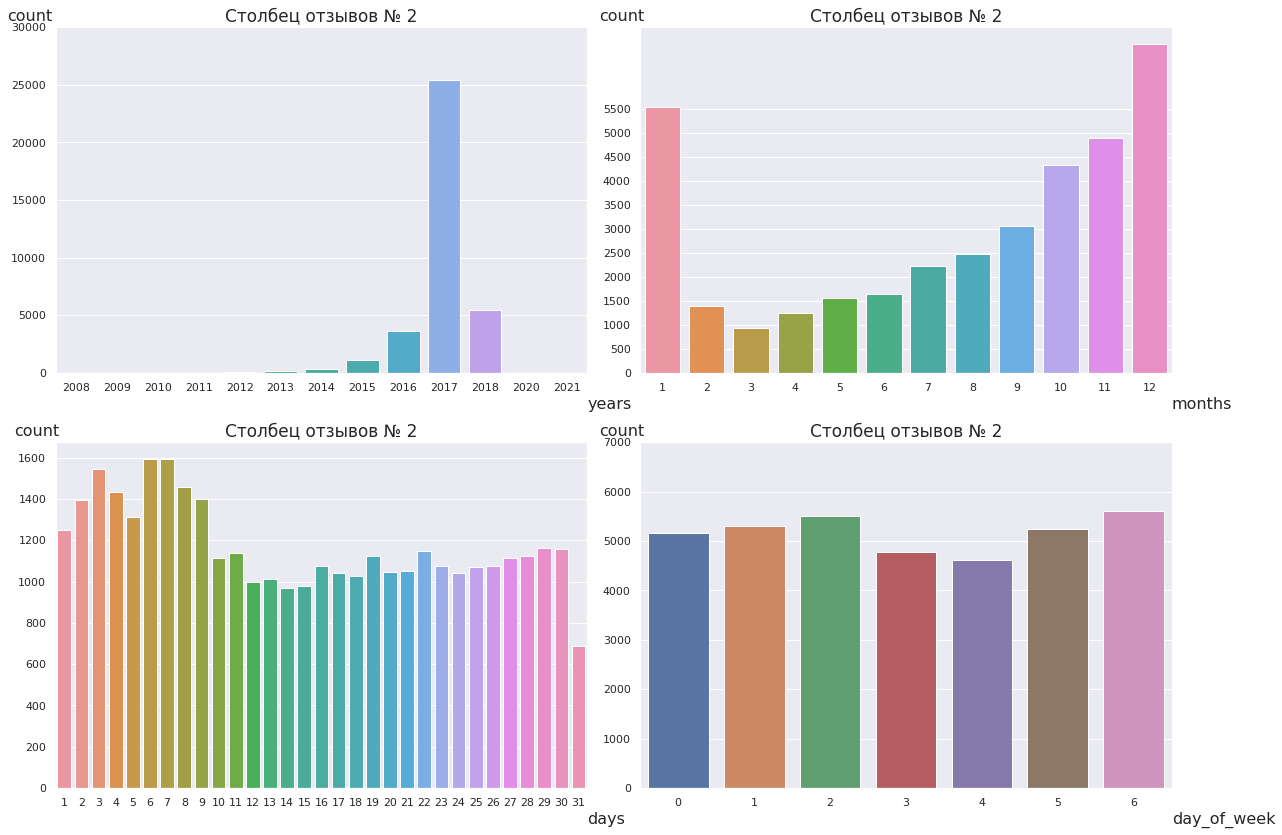

In [36]:
date_analise('2')

Как видно из представленных данных самым популярным годом является 2017. Люди больше ходят по ресторанам в конце и в самом начале года. Дни недели не так отличаются. Среди дней выделяется 31 число, что неудивительно, так как не у всех месяцев есть такой день.

Сформируем новые признаки на основе дат обзоров с учётом города для пропусков.

In [37]:
copy_data['year_date_1'] = 1
copy_data['year_date_2'] = 1
copy_data['month_date_1'] = 1
copy_data['month_date_2'] = 1
copy_data['day_of_month_date_1'] = 1
copy_data['day_of_month_date_2'] = 1

for city in copy_data.City.unique():
    mostly_year_1 = copy_data[copy_data.City==city].date_1.dt.year.value_counts().index[0]
    mostly_year_2 = copy_data[copy_data.City==city].date_2.dt.year.value_counts().index[0]
    mostly_month_1 = copy_data[copy_data.City==city].date_1.dt.month.value_counts().index[0]
    mostly_month_2 = copy_data[copy_data.City==city].date_2.dt.month.value_counts().index[0]
    mostly_day_1 = copy_data[copy_data.City==city].date_1.dt.day.value_counts().index[0]
    mostly_day_2 = copy_data[copy_data.City==city].date_2.dt.day.value_counts().index[0]

    # Приминительно к городам
    copy_data.loc[copy_data.City==city, 'year_date_1'] = copy_data[copy_data.City==city].date_1.apply(
                            lambda x: mostly_year_1 if pd.isnull(x) else x.year)
    copy_data.loc[copy_data.City==city, 'year_date_2'] = copy_data[copy_data.City==city].date_2.apply(
                            lambda x: mostly_year_2 if pd.isnull(x) else x.year)
    copy_data.loc[copy_data.City==city, 'month_date_1'] = copy_data[copy_data.City==city].date_1.apply(
                        lambda x: mostly_month_1 if pd.isnull(x) else x.month)
    copy_data.loc[copy_data.City==city, 'month_date_2'] = copy_data[copy_data.City==city].date_2.apply(
                        lambda x: mostly_month_2 if pd.isnull(x) else x.month)
    copy_data.loc[copy_data.City==city, 'day_of_month_date_1'] = copy_data[copy_data.City==city].date_1.apply(
                        lambda x: mostly_day_1 if pd.isnull(x) else x.day)
    copy_data.loc[copy_data.City==city, 'day_of_month_date_2'] = copy_data[copy_data.City==city].date_2.apply(
                        lambda x: mostly_day_2 if pd.isnull(x) else x.day)

cols = ['year_date_1', 'year_date_2', 'month_date_1', 'month_date_2',
        'day_of_month_date_1', 'day_of_month_date_2']
data_reviews_dates = copy_data[cols].copy()
data_reviews_dates.head(5)

,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2
0,2017.0,2017.0,10.0,12.0,4.0,7.0
1,2017.0,2017.0,10.0,12.0,29.0,5.0
2,2017.0,2017.0,12.0,12.0,6.0,28.0
3,2017.0,2017.0,11.0,12.0,22.0,6.0
4,2018.0,2018.0,1.0,2.0,24.0,8.0


Самым популярным годом является 2017, месяцы не сильно отличаются от друг друга, но есть тенденция, что люди больше постят отзывы в декабре-январе, т.е. на праздники. Распределение по дням тоже вполне ожидаемое (31 число особое), а дни недели почти не отличны друг от друга.

## Price Range

Посмотрим распределение цен.

In [38]:
copy_data = data.copy() # Чтоб ничего не испротить
copy_data['Price_Range'].value_counts()


$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

Заменим 17361 (см. раздел анализ ситуации с пропусками) пропуск модой. Этот вариант вполне очевиден, так как он самый массовый. Также имеет смысл сделать данный признак числовым. Это будет правильно, так как для машинного обучения такие параметры будут полезны.

In [39]:
# Заменяем пропуски на цифру 2
copy_data['Price_Range'] = copy_data['Price_Range'].apply(lambda x: 2 if pd.isnull(x) else x)

# Новый словарь, задающий числовое значение ценам.
price = {'$': 1, '$$ - $$$': 2, '$$$$': 3}

# Заменим все величины с помощью этого словаря
copy_data['Price_Range'] = copy_data['Price_Range'].replace(to_replace=price)

# Запомним этот дата сэт на будущее
data_Price_Range = copy_data[['Restaurant_id', 'Price_Range']]
data_Price_Range.head(5)

,Restaurant_id,Price_Range
0,id_0,2
1,id_1,2
2,id_2,2
3,id_3,3
4,id_4,3


Данный признак будет полезен для машинного обучения. Числовые переменные подобраны таким образом, чтобы установить отношение порядка. Также сформирован дата сэт, который в будущем будет использован.

## Number_of_Reviews

Number_of_Reviews - количество отзывов посетителей о ресторане. Ещё один полезный числовой признак. Проверим его на корреляцию с другими числовыми признаками.

In [40]:
copy_data = data[data['flag']==1].copy() # Чтоб не испортить

# Матрица корреляции
copy_data[['Ranking', 'Rating', 'Number_of_Reviews']].corr().round(2)

,Ranking,Rating,Number_of_Reviews
Ranking,1.00,-0.37,-0.22
Rating,-0.37,1.00,0.03
Number_of_Reviews,-0.22,0.03,1.00


Видим, что есть отрицательная связь между Number_of_Reviews и рангом. То есть разумно предположить, что чем меньше ранг, тем больше отзывов. Люди обычно ходят в хорошие места и делятся впечателениями. Также естественно, что чем больше город, тем больше туристов приходят в ресторан, тем больше отзывов они делают.

Проверим на экстремальные значения.

In [41]:
extr = data.Number_of_Reviews.max() # найдём максимальное число отзывов
print(extr)

print(data[data.Number_of_Reviews==extr].URL_TA.values) # найдём отзыв на сайте

9660.0
['/Restaurant_Review-g186338-d1421189-Reviews-London_Steakhouse_Co-London_England.html']


Да такой есть ресторан.
![](https://downloader.disk.yandex.ru/preview/150c17c73472803113f6ad9177af40770be19f8cc9c2f6d078ee4b6e19627e1f/60aed820/ru7tbM3g8CZjvQ8jtn3D_BkRQs4i_mm1LFdjwo6KQHUhjeik4oSQGSvq4LSOUdCzw5hlAMMs1XGlQ6LX_bZzYg%3D%3D?uid=0&filename=Extr.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)

Правда количество отзывов сильно приросло за пару лет. Также мы помним, что у нас есть пропуски в количестве 3200 штук. Заменим эти пропуски модой с учётом города.

In [42]:
copy_data = data.copy() # Мы же меняли его, так что заново

# Бежим по городам
for city in rest_city.index:
    # нашли моду
    value = copy_data[copy_data.City==city].Number_of_Reviews.value_counts().index[0]
    copy_data.loc[copy_data.City==city, 'Number_of_Reviews'] = \
            copy_data[copy_data.City==city].Number_of_Reviews.replace(np.nan, value)

# Проверяем себя
print(f'Число пропусков: {copy_data.Number_of_Reviews.isnull().sum()}')

# Создаём серию, потом понадобиться
data_Number_of_Reviews = copy_data[['Number_of_Reviews']]
data_Number_of_Reviews

Число пропусков: 0


,Number_of_Reviews
0,4.0
1,97.0
2,28.0
3,202.0
4,162.0
...,...
49995,79.0
49996,542.0
49997,4.0
49998,70.0


Установлено, что чем больше число отзывов, тем ранг ресторана ниже и наоборот.

## Cuisine_Style

Прежде чем перейти к обработке данного признака, надо подумать что делать с пропусками. Очевидным приёмом было бы заполнить пропуск кухней страны, в которой расположен город. Для этих целей был разработан на основе открытых источников дополнительный файл city_country_info.csv, содержащий следующие столбцы:
* City - город
* Country - страна
* Population - население города
* Pop_r - плотность населения
* Rest_count - число ресторанов
* Pop_per_rest - число горожан на один ресторан
* Rest_r - количество ресторанов на единицу площади (по площади города и числу ресторанов вычислилось)
* Tour_count - число туристов
* Tour_pop - отношение числа туристов и населения
* All_per_rest - отношение числа всех людей в городе к ресторанам
* HNADI - Чистый скорректированный располагаемый доход домохозяйства
* HNFW - Чистое финансовое благосостояние домашних хозяйств
* Personal_earnings - Личный заработок
* Educational_attainment - Уровень образования
* Life_expectancy - Продолжительность жизни
* Life_satisfaction - Удовлетворённость жизнью
* FSWAAN - Чувство безопасности
* Homicide_rate - Уровень криминала
* GDP_per_capita - ВВП на душу населения

Основная идея состояла в том, что хорошо бы знать что-то дополнительно про город, страну, про жителей.
Если уровень преступности высокий, то туристов будет меньше, а значит малое посещение ресторанов, значит и ресторанов меньше.
Или если высокий уровень ВВП на душу населения, значит люди больше могут себе позволить, могут сходить в ресторан, что подталкивает обсудить вечер не только в кругу семьи, но и поделиться в сети. Опять же туристы будут привлечены, а их надо кормить. Если человек хорошо зарабатывает, то и питается скорее всего он не через спар, а может сходить в ресторан и так далее и так далее.

К слову материалы я нашёл и подготовил на сайте [Организации экономического сотрудничества и развития](https://stats.oecd.org/).

In [43]:
# Загружаем таблицу
cities_data = pd.read_csv('/kaggle/input/city-country-info/city_country_info.csv', sep=';')
cities_data.head()

,City,Country,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita
0,Vienna,Austria,1897491,4503,3738,508,9,6410300,3.38,2223,32544,59574,48295,85,81.3,7.0,80.7,0.4,43724.031
1,Brussels,Belgium,179277,5497,3004,60,92,3942000,21.99,1372,29968,104084,49587,75,81.1,6.9,70.7,1.0,40106.632
2,Prague,Czech,1301132,2506,4631,281,9,8948600,6.88,2213,21103,24258,23722,93,78.7,6.6,68.3,0.8,17256.918
3,Copenhagen,Denmark,615993,6215,1968,313,20,3069700,4.98,1873,28950,73543,52580,81,80.8,7.5,83.0,0.7,52114.165
4,London,England,8908081,5667,16986,524,11,19233000,2.16,1657,28408,83405,42835,81,81.0,6.7,77.4,0.2,32238.000


Создадим новый дата сэт на основе исходного и только что подгруженными данными.

In [44]:
gen_data = pd.merge(data, cities_data, on='City', how='left') # general_data - обновленный дата сэт
gen_data.head()

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Rating,flag,Country,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,0,France,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,0,Finland,655281,3058,1444,454,7,4175012,6.37,3345,29374,27972,42127,88,81.6,7.5,82.9,1.4,41973.988
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,0,Scotland,488100,4140,1766,276,15,1660000,3.40,1216,32456,92465,41335,80,82.4,6.3,77.6,0.2,37460.000
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0.0,0,England,8908081,5667,16986,524,11,19233000,2.16,1657,28408,83405,42835,81,81.0,6.7,77.4,0.2,32238.000
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0.0,0,Slovakia,437725,1189,1041,420,3,1400056,3.20,1765,20265,10846,23508,92,76.7,6.1,60.1,0.8,15991.736


Построим матрицу корреляции и оценим ситуацию зависимостей признаков.

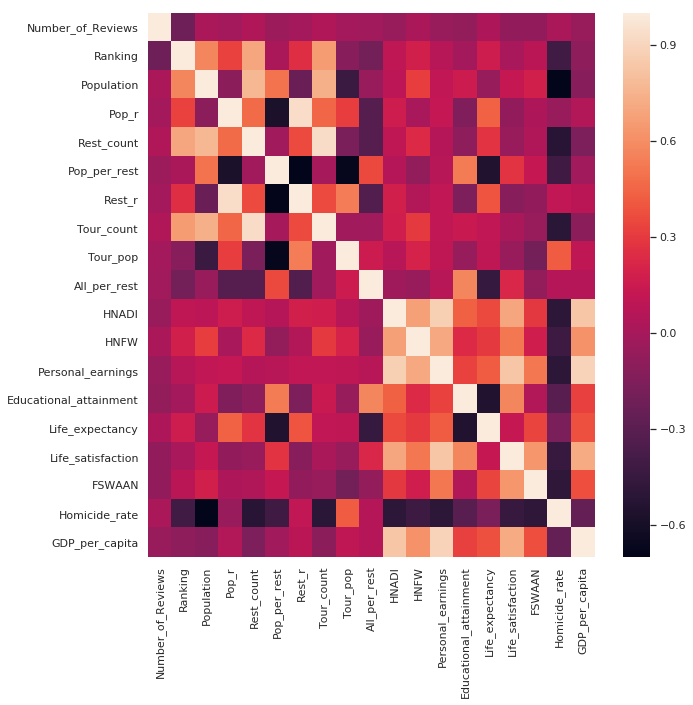

In [45]:
crl = gen_data[['Number_of_Reviews', 'Ranking', 'Population', 'Pop_r', 'Rest_count',
                'Pop_per_rest', 'Rest_r', 'Tour_count', 'Tour_pop', 'All_per_rest','HNADI', 'HNFW',
                'Personal_earnings', 'Educational_attainment', 'Life_expectancy', 'Life_satisfaction', 'FSWAAN',
                'Homicide_rate', 'GDP_per_capita']].corr().round(2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(crl);

In [46]:
display(crl)

,Number_of_Reviews,Ranking,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita
Number_of_Reviews,1.00,-0.22,0.02,-0.01,0.04,-0.04,-0.01,0.04,-0.01,-0.02,-0.05,0.02,-0.05,-0.07,0.03,-0.08,-0.08,0.02,-0.05
Ranking,-0.22,1.00,0.57,0.33,0.70,0.02,0.25,0.66,-0.12,-0.20,0.10,0.18,0.07,-0.01,0.16,0.01,0.08,-0.41,-0.09
Population,0.02,0.57,1.00,-0.10,0.77,0.50,-0.24,0.74,-0.44,-0.05,0.09,0.31,0.11,0.15,-0.06,0.13,0.18,-0.70,-0.12
Pop_r,-0.01,0.33,-0.10,1.00,0.47,-0.58,0.94,0.45,0.31,-0.32,0.16,0.01,0.12,-0.15,0.44,-0.08,0.03,-0.05,0.05
Rest_count,0.04,0.70,0.77,0.47,1.00,-0.02,0.36,0.93,-0.17,-0.32,0.10,0.23,0.06,-0.09,0.27,-0.05,0.04,-0.52,-0.16
Pop_per_rest,-0.04,0.02,0.50,-0.58,-0.02,1.00,-0.70,0.00,-0.68,0.35,0.06,-0.07,0.07,0.53,-0.55,0.27,0.13,-0.42,-0.02
Rest_r,-0.01,0.25,-0.24,0.94,0.36,-0.70,1.00,0.36,0.54,-0.34,0.18,0.05,0.11,-0.16,0.39,-0.12,-0.08,0.11,0.08
Tour_count,0.04,0.66,0.74,0.45,0.93,0.00,0.36,1.00,-0.02,-0.02,0.17,0.30,0.11,0.14,0.11,0.02,-0.05,-0.51,-0.10
Tour_pop,-0.01,-0.12,-0.44,0.31,-0.17,-0.68,0.54,-0.02,1.00,0.15,0.07,0.20,0.10,-0.06,0.10,-0.05,-0.20,0.42,0.10
All_per_rest,-0.02,-0.20,-0.05,-0.32,-0.32,0.35,-0.34,-0.02,0.15,1.00,-0.03,-0.05,0.07,0.57,-0.46,0.22,-0.07,0.06,0.06


Как видно новые признаки, а именно число ресторанов и ранг имеют корреляцию (чем больше ресторанов, тем больше рангов). Также видно обратную зависимость уровня преступности и туризма, уровня удовлетворённости жизнью и количеством населения и т.д. В дальнейшем мы поспользуемся этой информацией для построения новых признаков.

А теперь на основе обновленного дата сэта разберёмся с пропусками. Как было выше выяснено, мы в этом признаке имеем 11590 пропусков по данному столбцу. Давайте выясним предпочтения в каждой стране, чтобы потом воспользоваться этим для решения вопросов по пропускам.

### ВАЖНО!
Ранее при выполнении задания я выбрал следующий подход:
заполняю пропуски списком из одного элемента, а данные без пропусков по стили кухни я разбивал, и на основе этого делал отдельно взятые списки. Затем, чтобы выяснить какой стиль в стране самый предпочтительный, я вызывал value_counts(). Так вот в Anaconda Jupyter notebook эта операция проходила без ошибок. Но в Kaggle notebook происходило падение при вызове value_counts(), так как по правилам эта функция может применяться только к хэшированным типам данным (числам, строкам,..), но не к спискам. Поэтому пришлось делать общий подход (и для Kaggle, и для Anacond'ы), который будет реализован ниже в ячейках ноутбука.
Чтобы не забыть старый код (хоть он и есть в репе на гите), я сохраню его сюда.

def cuisine_update(cuisine):
    """"
    Переводит строку содержащию стили кухни в список.
    """

    if pd.isna(cuisine): return ['Unk'] # Если что-то идёт не так забьём строчкой Unk
    
    # Убираем скобки, кавычки, делаем разбивку
    cuisine = str(cuisine).strip('[]').replace('\'','').split(', ')

    return cuisine

copy_data = gen_data.copy() # Чтоб ничего не испортить

#Пометим пропуски Unk
copy_data.Cuisine_Style = copy_data.Cuisine_Style.apply(cuisine_update)
national_cuisine = {} # Национальные кухни (пока словарь)

for country in copy_data.Country.value_counts().index:
    name = copy_data[copy_data.Country == country].Cuisine_Style.value_counts().index[0]
    if name == ['Unk']:
        name = copy_data[copy_data.Country == country].Cuisine_Style.value_counts().index[1]
    national_cuisine[country] = name

#Делаем серию из словаря и выводим на экран
national_cuisine = pd.Series(national_cuisine)
national_cuisine

In [47]:
copy_data = gen_data.copy() # Чтоб ничего не испортить

# Пометим пропуски Unk
copy_data.Cuisine_Style = copy_data.Cuisine_Style.apply(cuisine_update)
national_cuisine = {} # Национальные кухни (пока словарь)

for country in copy_data.Country.value_counts().index:
    name = copy_data[copy_data.Country == country].Cuisine_Style.value_counts().index[0]
    if name == 'Unk':
        name = copy_data[copy_data.Country == country].Cuisine_Style.value_counts().index[1]
    national_cuisine[country] = [cstr for cstr in name.replace('\'','').split(', ')]# name.split(', ')

# Делаем серию из словаря и выводим на экран
national_cuisine = pd.Series(national_cuisine)
national_cuisine

France                                 [French]
Spain                                 [Spanish]
England                     [Bar, British, Pub]
Italy                                 [Italian]
Germany                               [Italian]
Portugal                 [European, Portuguese]
Czech                         [Czech, European]
Poland                       [European, Polish]
Austria                    [Austrian, European]
Netherlands                   [Dutch, European]
Belgium                     [Belgian, European]
Switzerland                   [European, Swiss]
Sweden                      [European, Swedish]
Hungary                   [European, Hungarian]
Ireland                       [Bar, Irish, Pub]
Denmark        [Danish, European, Scandinavian]
Greece                                  [Greek]
Scotland                                 [Cafe]
Norway                                    [Pub]
Finland                [European, Scandinavian]
Slovakia                                

Как видно из результата выше, в основном люди предпочитают национальную кухню. Но есть исключения - Герамния, Норвегия, Словакия, Шотландия, Финляндия. Логичное предложение все пропуски заменить на национальную кухню. Так для немецких ресторанов я предлагаю сделать пропуски как немецкая кухня, для норвежцев европейская/норвежская, для Шотландии ввиду близости к Англии заполним шотландской и английской и так далее. Подготовим список замен.

In [48]:
national_cuisine.loc['Germany'] = ['German']
national_cuisine.loc['Scotland'] = ['Bar', 'British', 'Pub', 'Scottish']
national_cuisine.loc['Finland'] = ['European, Scandinavian']
national_cuisine.loc['Norway'] = ['European', 'Norwegian']
national_cuisine.loc['Slovakia'] = ['Slovakian']
national_cuisine

France                                 [French]
Spain                                 [Spanish]
England                     [Bar, British, Pub]
Italy                                 [Italian]
Germany                                [German]
Portugal                 [European, Portuguese]
Czech                         [Czech, European]
Poland                       [European, Polish]
Austria                    [Austrian, European]
Netherlands                   [Dutch, European]
Belgium                     [Belgian, European]
Switzerland                   [European, Swiss]
Sweden                      [European, Swedish]
Hungary                   [European, Hungarian]
Ireland                       [Bar, Irish, Pub]
Denmark        [Danish, European, Scandinavian]
Greece                                  [Greek]
Scotland          [Bar, British, Pub, Scottish]
Norway                    [European, Norwegian]
Finland                [European, Scandinavian]
Slovakia                            [Slo

Заменяем пропуски

In [49]:
# Помечаем пропуски
gen_data.Cuisine_Style = copy_data.Cuisine_Style.apply(cuisine_list)

# Обновляем
gen_data = gen_data.apply(lambda row: fill_ncuisine(row), axis=1)
print(f'Контроль\nКоличество пропусков: {gen_data.Cuisine_Style.isnull().sum()}')

Контроль
Количество пропусков: 0


Так как в дальнейшем мы будем обучать модель, которая работает только с числовыми данными, сделаем dummy переменные для признака кухни. Это правильнее, чем сделать как ценовой вилкой. Там это было обоснованно, так как неободимо дать понять машине, что есть отношение порядка (где-то дешевле, где-то дороже). Здесь же этого делать не стоит, так паб не больше и не меньше, чем норвежская кухня. Это просто тип такой. Поэтому вперёд за дамми!

In [50]:
dummy_data = gen_data[['Cuisine_Style']].copy() # Чтобы не испортить

mlb = MultiLabelBinarizer()
dummy_Cuisine_Style = pd.DataFrame(mlb.fit_transform(dummy_data['Cuisine_Style']), columns=mlb.classes_)
dummy_Cuisine_Style

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
49996,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [51]:
# Проверка на количество стилей кухонь. Должно быть, как выше 127
gen_data.explode('Cuisine_Style').Cuisine_Style.nunique()

127

Создадим ещё один признак - количество стилей кухонь в ресторане

In [52]:
gen_data['Cuisine_count'] = gen_data.Cuisine_Style.apply(len)
gen_data.head()

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Rating,flag,Country,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,0,France,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006,2
1,id_1,Helsinki,"[European, GlutenFreeOptions, Scandinavian, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,0,Finland,655281,3058,1444,454,7,4175012,6.37,3345,29374,27972,42127,88,81.6,7.5,82.9,1.4,41973.988,5
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,0,Scotland,488100,4140,1766,276,15,1660000,3.40,1216,32456,92465,41335,80,82.4,6.3,77.6,0.2,37460.000,1
3,id_3,London,"[European, GlutenFreeOptions, Italian, Mediter...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0.0,0,England,8908081,5667,16986,524,11,19233000,2.16,1657,28408,83405,42835,81,81.0,6.7,77.4,0.2,32238.000,5
4,id_4,Bratislava,"[European, GlutenFreeOptions, Italian, Mediter...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0.0,0,Slovakia,437725,1189,1041,420,3,1400056,3.20,1765,20265,10846,23508,92,76.7,6.1,60.1,0.8,15991.736,6


## 2. Окончательная таблица

Будем последовательно готовить составляющие данные нового дата сэта. Начнём с городов и стран. Сделаем по образу и подобию как с кухней, применяя только в этот раз LabelBinarizer.

In [53]:
dummy_data = gen_data.copy() # Чтобы не испортить

lblbinarizer = LabelBinarizer()

# Города
city_bin = lblbinarizer.fit_transform(dummy_data['City'])
dummy_city = pd.DataFrame(city_bin, columns=lblbinarizer.classes_)
display(dummy_city)

# Страны
country_bin = lblbinarizer.fit_transform(dummy_data['Country'])
dummy_country = pd.DataFrame(country_bin, columns=lblbinarizer.classes_)
display(dummy_country)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


,Austria,Belgium,Czech,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Luxembourg,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Подключаем отзывы и дни между отзывами (там заполненные пропуски)

In [54]:
gen_data['Number_of_Reviews'] = data_Number_of_Reviews['Number_of_Reviews']
gen_data['days_reviews'] = data_reviews['days_number']

Обновляем Price_Range на числовые данные.

In [55]:
gen_data['Price_Range'] = data_Price_Range['Price_Range']

Подключаем дни, месяцы и годы.

In [56]:
gen_data = gen_data.join(data_reviews_dates)

Дамми кухни.

In [57]:
gen_data = gen_data.join(dummy_Cuisine_Style)

Дамми города, дамми страны.

In [58]:
gen_data = gen_data.join(dummy_city)

# Приходится заменить в дамми странах такие наименования 'Czech', 'Luxembourg',
# так как они уже есть в дамми кухнях
dummy_country['CCzech'] = dummy_country['Czech']
dummy_country['CLuxembourg'] = dummy_country['Luxembourg']
dummy_country.drop(['Czech', 'Luxembourg'], axis=1, inplace=True)

gen_data = gen_data.join(dummy_country)

In [59]:
# Что же получилось?
gen_data.head()

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Rating,flag,Country,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count,days_reviews,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland,CCzech,CLuxembourg
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,0,France,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006,2,67.0,2017.0,2017.0,10.0,12.0,4.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, GlutenFreeOptions, Scandinavian, Ve...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,0,Finland,655281,3058,1444,454,7,4175012,6.37,3345,29374,27972,42127,88,81.6,7.5,82.9,1.4,41973.988,5,37.0,2017.0,2017.0,10.0,12.0,29.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,[VegetarianFriendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,0,Scotland,488100,4140,1766,276,15,1660000,3.40,1216,32456,92465,41335,80,82.4,6.3,77.6,0.2,37460.000,1,22.0,2017.0,2017.0,12.0,12.0,6.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Сделаем ещё пару-тройку признаков.

In [60]:
gen_data['ext_0'] = gen_data.Ranking / gen_data.Population
gen_data['ext_1'] = gen_data.Ranking + gen_data.Pop_r
gen_data['ext_2'] = gen_data.Ranking / gen_data.Rest_count
gen_data['ext_3'] = gen_data.Ranking + gen_data.Rest_r
gen_data['ext_4'] = gen_data.Ranking - gen_data.Tour_count
gen_data['ext_5'] = gen_data.Ranking * gen_data.Homicide_rate
gen_data['ext_6'] = gen_data.Tour_count * gen_data.Homicide_rate
gen_data['ext_7'] = gen_data.Pop_per_rest * gen_data.Life_satisfaction
gen_data['ext_8'] = gen_data.Number_of_Reviews * gen_data.Life_expectancy

Создаём окончательный набор, отбрасывая все текстовые элементы.

In [61]:
final_data = gen_data.copy() # На всякий случай

# Удаляем ненужные столбцы
final_data.drop(['Restaurant_id', 'Cuisine_Style', 'Reviews',
                 'URL_TA', 'ID_TA', 'City', 'Country'], axis=1, inplace=True)

display(final_data.head())
display(final_data.tail())
final_data.dropna()

,Ranking,Price_Range,Number_of_Reviews,Rating,flag,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count,days_reviews,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland,CCzech,CLuxembourg,ext_0,ext_1,ext_2,ext_3,ext_4,ext_5,ext_6,ext_7,ext_8
0,12963.0,2,4.0,0.0,0,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006,2,67.0,2017.0,2017.0,10.0,12.0,4.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006034,33744.0,0.838107,13113.0,-17547237.0,7777.8,10536120.0,889.6,329.6
1,106.0,2,97.0,0.0,0,655281,3058,1444,454,7,4175012,6.37,3345,29374,27972,42127,88,81.6,7.5,82.9,1.4,41973.988,5,37.0,2017.0,2017.0,10.0,12.0,29.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000162,3164.0,0.073407,113.0,-4174906.0,148.4,5845016.8,3405.0,7915.2
2,810.0,2,28.0,0.0,0,488100,4140,1766,276,15,1660000,3.40,1216,32456,92465,41335,80,82.4,6.3,77.6,0.2,37460.000,1,22.0,2017.0,2017.0,12.0,12.0,6.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.001659,4950.0,0.458664,825.0,-1659190.0,162.0,332000.0,1738.8,2307.2
3,1669.0,3,202.0,0.0,0,8908081,5667,16986,524,11,19233000,2.16,1657,28408,83405,42835,81,81.0,6.7,77.4,0.2,32238.000,5,14.0,2017.0,2017.0,11.0,12.0,22.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0

,Ranking,Price_Range,Number_of_Reviews,Rating,flag,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count,days_reviews,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland,CCzech,CLuxembourg,ext_0,ext_1,ext_2,ext_3,ext_4,ext_5,ext_6,ext_7,ext_8
49995,500.0,2,79.0,4.5,1,1378689,7589,6668,207,37,6481300,4.70,1179,26063,64019,35397,60,82.6,5.9,58.3,0.8,29866.581,4,34.0,2017.0,2017.0,11.0,12.0,12.0,16.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.000363,8089.0,0.074985,537.0,-6480800.0,400.0,5185040.0,1221.3,6525.4
49996,6341.0,2,542.0,3.5,1,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006,5,9.0,2017.0,2017.0,12.0,12.0,12.0,21.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002952,27122.0,0.409970,6491.0,-17553859.0,3804.6,10536120.0,889.6,44660.8
49997,1652.0,2,4.0,4.5,1,961609,5140,2729,352,15,2604600,2.71,1307,30553,90708,42816,83,82.3,7.3,75.9,1.0,49866.266,2,3127.0,2008.0,2016.0,4.0,11.0,12.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.001718,6792.0,0.605350,1667.0,-2602948.0,1652.0,2604600.0,2569.6,329.2
49998,641.0,2,70.0,4.0,1,1790658,3449,2739,654,5,2850000,1.59,1694,18906,14997,25921,91,77.6,6.0,66.3,0.8,12495.334,5,23.0,2017.0,2017.0,6.0,7.0,18.0,11.0,0,0,

,Ranking,Price_Range,Number_of_Reviews,Rating,flag,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count,days_reviews,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland,CCzech,CLuxembourg,ext_0,ext_1,ext_2,ext_3,ext_4,ext_5,ext_6,ext_7,ext_8
0,12963.0,2,4.0,0.0,0,2148327,20781,15467,139,150,17560200,8.17,1274,31137,59479,42992,78,82.4,6.4,69.6,0.6,37675.006,2,67.0,2017.0,2017.0,10.0,12.0,4.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006034,33744.0,0.838107,13113.0,-17547237.0,7777.8,10536120.0,889.6,329.6
1,106.0,2,97.0,0.0,0,655281,3058,1444,454,7,4175012,6.37,3345,29374,27972,42127,88,81.6,7.5,82.9,1.4,41973.988,5,37.0,2017.0,2017.0,10.0,12.0,29.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000162,3164.0,0.073407,113.0,-4174906.0,148.4,5845016.8,3405.0,7915.2
2,810.0,2,28.0,0.0,0,488100,4140,1766,276,15,1660000,3.40,1216,32456,92465,41335,80,82.4,6.3,77.6,0.2,37460.000,1,22.0,2017.0,2017.0,12.0,12.0,6.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.001659,4950.0,0.458664,825.0,-1659190.0,162.0,332000.0,1738.8,2307.2
3,1669.0,3,202.0,0.0,0,8908081,5667,16986,524,11,19233000,2.16,1657,28408,83405,42835,81,81.0,6.7,77.4,0.2,32238.000,5,14.0,2017.0,2017.0,11.0,12.0,22.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0

In [62]:
final_data.describe()

,Ranking,Price_Range,Number_of_Reviews,Rating,flag,Population,Pop_r,Rest_count,Pop_per_rest,Rest_r,Tour_count,Tour_pop,All_per_rest,HNADI,HNFW,Personal_earnings,Educational_attainment,Life_expectancy,Life_satisfaction,FSWAAN,Homicide_rate,GDP_per_capita,Cuisine_count,days_reviews,year_date_1,year_date_2,month_date_1,month_date_2,day_of_month_date_1,day_of_month_date_2,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,BrewPub,British,Burmese,Cafe,Cajun&Creole,Cambodian,Canadian,Caribbean,Caucasian,CentralAmerican,CentralAsian,CentralEuropean,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,EasternEuropean,Ecuadorean,Egyptian,Ethiopian,European,"European, Scandinavian",FastFood,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,GlutenFreeOptions,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,MiddleEastern,MinorityChinese,Mongolian,Moroccan,NativeAmerican,Nepali,NewZealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovakian,Slovenian,Soups,SouthAmerican,Southwestern,Spanish,SriLankan,Steakhouse,StreetFood,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,VeganOptions,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Denmark,England,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Netherlands,Norway,Poland,Portugal,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland,CCzech,CLuxembourg,ext_0,ext_1,ext_2,ext_3,ext_4,ext_5,ext_6,ext_7,ext_8
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,5000

Флаги на месте, новые признаки тоже. Приступаем к самому сложному.

## Машинное обучение
Разделяем данные: по условию первых 40000 строк - для обучения, остальные 10000 для тестов.

In [63]:
training_data = final_data.query('flag == 1').drop(['flag'], axis=1)
kaggling_data = final_data.query('flag == 0').drop(['flag'], axis=1)
print(f'Контрольная печать размеров {training_data.shape}, {kaggling_data.shape}')

Контрольная печать размеров (40000, 219), (10000, 219)


Протестируем обучение.

In [64]:
# Х - аргумент, у - целевая переменная
X = training_data.drop(['Rating'], axis = 1)
y = training_data.Rating.values

# train для обучения модели, test - для тестирования.
# Для тестирования берём 20% от исходного дата сэта.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, X_train.shape, X_test.shape

((40000, 218), (32000, 218), (8000, 218))

Создаём, обучаем и тестируем модель

In [65]:
# Создание модели
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для тестовой выборки.
y_pred = regr.predict(X_test)
y_pred = np.round(y_pred * 2) / 2

# Сравниваем y_pred с y_test
print(f"MAE: {(metrics.mean_absolute_error(y_test, y_pred)).round(3)}")

MAE: 0.169


Решение для Kaggle.

In [66]:
kaggling_data = kaggling_data.drop(['Rating'], axis=1)
predict_submission = regr.predict(kaggling_data)
predict_submission = np.round(predict_submission * 2) / 2

sample_submission = kaggle_task[['Restaurant_id', 'City']].copy()
sample_submission['Rating'] = predict_submission
sample_submission.drop('City', axis=1, inplace=True)
sample_submission.to_csv('submission.csv', index=False)

In [67]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
